In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
from typing import Sequence, NamedTuple
import json

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import itertools

---
# Code
---
# Deep Linear Network

In [2]:
# Define the DLN model
class DeepLinearNetwork(hk.Module):
    def __init__(self, layer_widths: Sequence[int], name: str = None, with_bias=False):
        super().__init__(name=name)
        self.layer_widths = layer_widths
        self.with_bias = with_bias

    def __call__(self, x):
        for width in self.layer_widths:
            x = hk.Linear(width, with_bias=self.with_bias)(x)
        return x

# Function to initialize and apply the DLN model
def forward_fn(x, layer_widths):
    net = DeepLinearNetwork(layer_widths)
    return net(x)

# Create a Haiku-transformed version of the model
def create_model(layer_widths):
    model = hk.without_apply_rng(hk.transform(lambda x: forward_fn(x, layer_widths)))
    return model


def generate_training_data(true_param, model, input_dim, num_samples):
    # Generate random inputs
    inputs = np.random.uniform(-10, 10, size=(num_samples, input_dim))

    # Apply the true model to generate outputs
    true_outputs = model.apply(true_param, inputs)

    return inputs, true_outputs

def mse_loss(param, model, inputs, targets):
    predictions = model.apply(param, inputs)
    return jnp.mean((predictions - targets) ** 2)


def create_minibatches(inputs, targets, batch_size, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    else:
        indices = np.arange(len(inputs))

    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield inputs[excerpt], targets[excerpt]


## SGLD code

In [3]:

class SGLDConfig(NamedTuple):
  epsilon: float
  gamma: float
  num_steps: int

def generate_rngkey_tree(key_or_seed, tree_or_treedef):
    rngseq = hk.PRNGSequence(key_or_seed)
    return jtree.tree_map(lambda _: next(rngseq), tree_or_treedef)

def optim_sgld(epsilon, rngkey_or_seed):
    @jax.jit
    def sgld_delta(g, rngkey):
        eta = jax.random.normal(rngkey, shape=g.shape) * jnp.sqrt(epsilon)
        return -epsilon * g / 2 + eta

    def init_fn(_):
        return rngkey_or_seed

    @jax.jit
    def update_fn(grads, state):
        rngkey, new_rngkey = jax.random.split(state)
        rngkey_tree = generate_rngkey_tree(rngkey, grads)
        updates = jax.tree_map(sgld_delta, grads, rngkey_tree)
        return updates, new_rngkey
    return optax.GradientTransformation(init_fn, update_fn)


def create_local_logposterior(avgnegloglikelihood_fn, num_training_data, w_init, gamma, itemp):
    def helper(x, y):
        return jnp.sum((x - y)**2)

    def _logprior_fn(w):
        sqnorm = jax.tree_util.tree_map(helper, w, w_init)
        return jax.tree_util.tree_reduce(lambda a,b: a + b, sqnorm)

    def logprob(w, x, y):
        loglike = -num_training_data * avgnegloglikelihood_fn(w, x, y)
        logprior = -gamma / 2 * _logprior_fn(w)
        return itemp * loglike + logprior
    return logprob


## Compute DLN true learning coefficients

Reference:
Aoyagi, Miki. 2023. “Consideration on the Learning Efficiency Of Multiple-Layered Neural Networks with Linear Units.” https://doi.org/10.2139/ssrn.4404877.

In [4]:
def true_dln_learning_coefficient(true_rank, layer_widths, input_dim, verbose=False):
    M_list = np.array([input_dim] + list(layer_widths)) - true_rank
    indices = brute_force_search_subset(M_list, early_return=verbose)
    M_subset = M_list[indices]
    if verbose:
        print(f"M_list: {M_list}, indices: {indices}, M_subset: {M_subset}")
    M_subset_sum = np.sum(M_subset)
    ell = len(M_subset) - 1
    M = np.ceil(M_subset_sum / ell)
    a = M_subset_sum - (M - 1) * ell
    output_dim = layer_widths[-1]

    term1 = (-true_rank**2 + true_rank * (output_dim + input_dim)) / 2
    term2 = a * (ell - a) / (4 * ell)
    term3 = -ell * (ell - 1) / 4 * (M_subset_sum / ell)**2
    term4 = 1 / 2 * np.sum([M_subset[i] * M_subset[j] for i in range(ell + 1) for j in range(i + 1, ell + 1)])
    learning_coefficient = term1 + term2 + term3 + term4
    return learning_coefficient

def _condition(indices, intlist, verbose=False):
    intlist = np.array(intlist)
    ell = len(indices) - 1
    subset = intlist[indices]
    complement = intlist[[i for i in range(len(intlist)) if i not in indices]]
    has_complement = len(complement) > 0
    # print(indices, subset, complement)
    if has_complement and not (np.max(subset) < np.min(complement)):
        if verbose: print(f"max(subset) = {np.max(subset)}, min(complement) = {np.min(complement)}")
        return False
    if not (np.sum(subset) >= ell * np.max(subset)):
        if verbose: print(f"sum(subset) = {sum(subset)}, ell * max(subset) = {ell * np.max(subset)}")
        return False
    if has_complement and not (np.sum(subset) < ell * np.min(complement)):
        if verbose: print(f"sum(subset) = {sum(subset)}, ell * min(complement) = {ell * np.min(complement)}")
        return False
    return True


def generate_indices_subsets(length):
    indices = list(range(length))
    for size in range(1, length + 1):
        for subset in itertools.combinations(indices, size):
            subset = np.array(subset)
            yield subset


def brute_force_search_subset(intlist, early_return=False):
    candidates = []
    for indices in generate_indices_subsets(len(intlist)):
        if _condition(indices, intlist):
            if early_return:
                return indices
            candidates.append(indices)
    if len(candidates) == 0:
        raise RuntimeError("No candidates")
    if len(candidates) > 1:
        print("More than one candidate")
    return candidates[0]


def to_float_or_list(x):
    if isinstance(x, (float, int)):
        return float(x)
    elif isinstance(x, (list, tuple)):
        return [float(el) for el in x]
    elif hasattr(x, "tolist"):  # For JAX or numpy arrays
        return x.tolist()
    else:
        raise ValueError(f"Unsupported type {type(x)}")

def to_json_friendly_tree(tree):
    return jtree.tree_map(to_float_or_list, tree)


def reduce_matrix_rank(matrix, reduction):
    """
    Reduce the rank of the matrix by 'reduction' amount.

    :param matrix: Input matrix.
    :param reduction: The amount by which the rank should be reduced.
    :return: A matrix similar to the input but with reduced rank.
    """
    U, S, Vh = np.linalg.svd(matrix, full_matrices=False)

    # Reduce the number of non-zero singular values by 'reduction'
    new_rank = max(len(S) - reduction, 0)
    S[new_rank:] = 0

    # Reconstruct the matrix with the reduced number of singular values
    reduced_matrix = np.dot(U * S, Vh)
    return reduced_matrix

def rand_reduce_matrix_rank(matrix):
    r = np.linalg.matrix_rank(matrix)
    reduction = np.random.randint(0, max(1, r))
    return reduce_matrix_rank(matrix, reduction)


---
# Experiments
---
## Initialising and training network

In [6]:

# layer_widths = [20, 100, 20]
layer_widths = [89, 467, 95, 231, 59, 159, 36, 225, 210, 342, 457, 495, 366, 186]
input_dim = 100  # Dimension of the input
num_training_data = 10000  # Number of training samples

# Create the DLN model
model = create_model(layer_widths)

# Initialize the "true" model parameters
rngkey = jax.random.PRNGKey(0)
dummy_input = jnp.zeros((1, input_dim))
rngkey, subkey = jax.random.split(rngkey)
true_param = model.init(rngkey, dummy_input)

# Generate training data
x_train, y_train = generate_training_data(true_param, model, input_dim, num_training_data)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"Num param: {sum([np.prod(x.shape) for x in jtree.tree_leaves(true_param)])}")
jtree.tree_map(lambda x: x.shape, true_param)

x_train shape: (10000, 100), y_train shape: (10000, 186)
Num param: 904432


{'deep_linear_network/linear': {'w': (100, 89)},
 'deep_linear_network/linear_1': {'w': (89, 467)},
 'deep_linear_network/linear_10': {'w': (342, 457)},
 'deep_linear_network/linear_11': {'w': (457, 495)},
 'deep_linear_network/linear_12': {'w': (495, 366)},
 'deep_linear_network/linear_13': {'w': (366, 186)},
 'deep_linear_network/linear_2': {'w': (467, 95)},
 'deep_linear_network/linear_3': {'w': (95, 231)},
 'deep_linear_network/linear_4': {'w': (231, 59)},
 'deep_linear_network/linear_5': {'w': (59, 159)},
 'deep_linear_network/linear_6': {'w': (159, 36)},
 'deep_linear_network/linear_7': {'w': (36, 225)},
 'deep_linear_network/linear_8': {'w': (225, 210)},
 'deep_linear_network/linear_9': {'w': (210, 342)}}

In [7]:
%%time 
learning_rate = 0.01
optimizer = optax.sgd(learning_rate, momentum=0.9)
num_epochs = 100
batch_size = 200

rngkey, subkey = jax.random.split(rngkey)
param = model.init(rngkey, jnp.zeros((1, input_dim)))
opt_state = optimizer.init(param)

loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))
grad_fn = jax.jit(jax.grad(loss_fn, argnums=0))

t = 0
for epoch in range(num_epochs):
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
        grads = grad_fn(param, x_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        param = optax.apply_updates(param, updates)
        t += 1
    if epoch % 10 == 0:
        loss_val = mse_loss(param, model, x_train, y_train)
        print(f"Epoch {epoch}, Loss: {loss_val}")

trained_param = param
print(f"Num SGD steps: {t}")

Epoch 0, Loss: 0.31773048639297485


KeyboardInterrupt: 

## Hessian and functional rank

In [9]:
# Assuming the input distribution is sampled uniformly from the input ball, this
# will be the average of the empirical loss
def make_population_loss_fn2(true_param):
    first_linear = true_param['deep_linear_network/linear']['w']
    input_dim = first_linear.shape[0]
    true_prod = np.eye(input_dim)
    for p in true_param.values():
        true_prod = true_prod @ p['w']
        output_dim = p['w'].shape[1]
    def population_loss(param):
        prod = jnp.eye(input_dim)
        for p in param.values():
            prod = prod @ p['w']
        Q = true_prod - prod
        return jnp.sum(Q*Q) / ((input_dim+2) * output_dim)
    return population_loss

def pack_params(params):
    params_flat, treedef = jax.tree_util.tree_flatten(params)
    shapes = [p.shape for p in params_flat]
    indices = np.cumsum([p.size for p in params_flat])
    params_packed = jnp.concatenate([jnp.ravel(p) for p in params_flat])
    pack_info = (treedef, shapes, indices)
    return params_packed, pack_info

def unpack_params(params_packed, pack_info):
    treedef, shapes, indices = pack_info
    params_split = jnp.split(params_packed, indices)
    params_flat = [jnp.reshape(p, shape) for p, shape in zip(params_split, shapes)]
    params = jax.tree_util.tree_unflatten(treedef, params_flat)
    return params

# Hessian
true_param_packed, pack_info = pack_params(true_param)
loss_fn = lambda p_packed: make_population_loss_fn2(true_param)(unpack_params(p_packed, pack_info))

hessian = np.asarray(jax.hessian(loss_fn)(true_param_packed))
eigvals = np.linalg.eigvalsh(hessian)
fig = go.Figure(data=[go.Histogram(x=eigvals)])
fig.update_layout(
    title="Histogram of Hessian Eigenvalues", 
    xaxis_title="Hessian Eigenvalues", 
    yaxis_title="Frequency", 
    yaxis_type="log",
    # xaxis_type="log"
)

In [13]:
# n_small = 51
# x_small, y_small = generate_training_data(true_param, model, input_dim, n_small)
# fn = jax.jit(lambda param: model.apply(param, x_small))
# jacobian_fn = jax.jit(jax.jacrev(fn))
# jacobian_matrix = jnp.hstack([x.reshape(n_small * input_dim, -1) for x in jtree.tree_leaves(jacobian_fn(true_param))])
# svdvals = jnp.linalg.svd(jacobian_matrix, compute_uv=False)

def pack_params(params):
    params_flat, treedef = jax.tree_util.tree_flatten(params)
    shapes = [p.shape for p in params_flat]
    indices = np.cumsum([p.size for p in params_flat])
    params_packed = jnp.concatenate([jnp.ravel(p) for p in params_flat])
    pack_info = (treedef, shapes, indices)
    return params_packed, pack_info

def unpack_params(params_packed, pack_info):
    treedef, shapes, indices = pack_info
    params_split = jnp.split(params_packed, indices)
    params_flat = [jnp.reshape(p, shape) for p, shape in zip(params_split, shapes)]
    params = jax.tree_util.tree_unflatten(treedef, params_flat)
    return params

n_small = 51
threshold = 0.001
x_small, y_small = generate_training_data(true_param, model, input_dim, n_small)
true_param_flat, treedef = jtree.tree_flatten(true_param)
fn = jax.jit(lambda param: model.apply(jtree.tree_unflatten(treedef, param), x_small))
jacobian_fn = jax.jit(jax.jacrev(fn))
jacobian_matrix = jacobian_fn(true_param_flat)
svdvals = jnp.linalg.svd(jacobian_matrix, compute_uv=False)

fig = go.Figure(data=[go.Histogram(x=svdvals)])
fig.update_layout(
    title="Histogram of SVD Values", 
    xaxis_title="Singular Value", 
    yaxis_title="Frequency", 
    yaxis_type="log"
)
print(np.sum(svdvals > 0.001))

TypeError: jnp.linalg.svd requires ndarray or scalar arguments, got <class 'list'> at position 0.

## SGLD on the true param

Step 200, nll: 1551.0682373046875
Step 400, nll: 2810.329833984375
Step 600, nll: 3881.985107421875
Step 800, nll: 5040.2138671875
Step 1000, nll: 5979.767578125


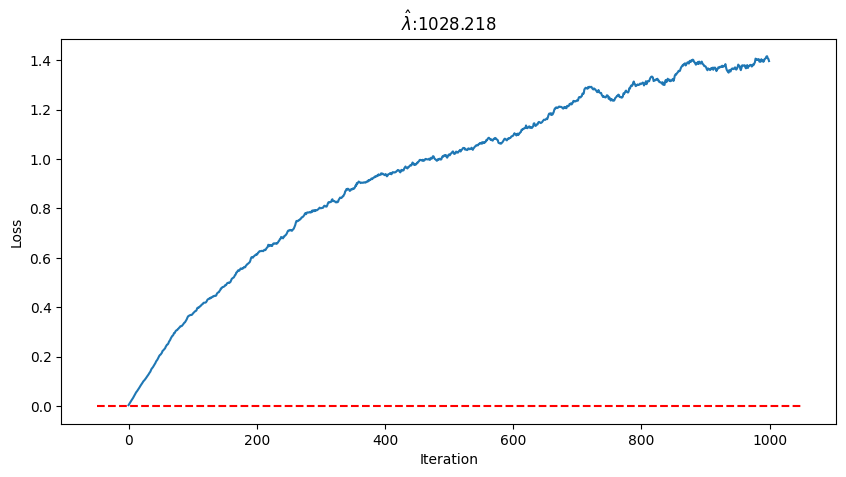

In [12]:

sgld_config = SGLDConfig(
    epsilon=1e-6,
    gamma=10.0,
    num_steps=1000,
)
itemp = 1 / np.log(num_training_data)
param_init = true_param

local_logprob = create_local_logposterior(
        avgnegloglikelihood_fn=loss_fn,
        num_training_data=num_training_data,
        w_init=param_init,
        gamma=sgld_config.gamma,
        itemp=itemp,
    )
sgld_grad_fn = jax.jit(jax.value_and_grad(lambda w, x, y: -local_logprob(w, x, y), argnums=0))


rngkey, subkey = jax.random.split(rngkey)
sgldoptim = optim_sgld(sgld_config.epsilon, rngkey)
samples = []
nlls = []
opt_state = sgldoptim.init(param_init)
param = param_init
t = 0
while t < sgld_config.num_steps:
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
        nll, grads = sgld_grad_fn(param, x_batch, y_batch)
        nlls.append(float(nll))
        updates, opt_state = sgldoptim.update(grads, opt_state)
        param = optax.apply_updates(param, updates)
        samples.append(param)
        t += 1
        if t % 200 == 0:
            print(f"Step {t}, nll: {nll}")

init_loss = loss_fn(param_init, x_train, y_train)
loss_trace = [loss_fn(p, x_train, y_train) for p in samples]
lambdahat = (np.mean(loss_trace) - init_loss) * num_training_data * itemp


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(loss_trace)
ax.set_title("$\hat{\lambda}$:" + f"{lambdahat:.3f}")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
xmin, xmax = ax.get_xlim()
ax.hlines(init_loss, xmin, xmax, colors="r", linestyles="dashed")

In [13]:
true_matrix = jnp.linalg.multi_dot(
    [true_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
)
true_rank = jnp.linalg.matrix_rank(true_matrix)
true_lambda = true_dln_learning_coefficient(true_rank, layer_widths, input_dim, verbose=True)
print(f"True matrix shape={true_matrix.shape}")
print(f"Input dim: {input_dim}")
print(f"Layer widths: {layer_widths}")
print(f"True lambda: {true_lambda}")
print(f"Estimated lambda: {lambdahat}")


M_list: [ 64  53 431  59 195  23 123   0 189 174 306 421 459 330 150], indices: [5 7], M_subset: [23  0]
True matrix shape=(100, 186)
Input dim: 100
Layer widths: [89, 467, 95, 231, 59, 159, 36, 225, 210, 342, 457, 495, 366, 186]
True lambda: 4500.0
Estimated lambda: 1028.2181396484375


## Sweeping through different DLN + true parameter

In [28]:
%%time
sgld_config = SGLDConfig(
    epsilon=1e-5,
    gamma=10.0,
    num_steps=5000, 
)
num_training_data = 10000  # Number of training samples
num_epochs = 50
batch_size = 100
num_sgd_steps = num_epochs * (num_training_data // batch_size)

num_checkpoints = 0
if num_checkpoints > 0:
    checkpoint_freq = num_sgd_steps // num_checkpoints
    checkpoint_steps = list(range(checkpoint_freq, num_sgd_steps + 1, checkpoint_freq))
else:
    checkpoint_steps = []
print(checkpoint_steps)
itemp = 1 / np.log(num_training_data)
learning_rate = 0.01
optimizer = optax.sgd(learning_rate)


num_expt = 2
expt_rec = []
rngkey = jax.random.PRNGKey(42)
for expt_i in range(num_expt):
    # expt configs
    num_layer = np.random.randint(2, 20)
    layer_widths = list(np.random.randint(5, 30, size=num_layer))
    input_dim = np.random.randint(5, 20)

    # Random true parameters
    model = create_model(layer_widths)
    dummy_input = jnp.zeros((1, input_dim))
    rngkey, subkey = jax.random.split(rngkey)
    # true_param = model.init(rngkey, dummy_input)
    # true_param = jtree.tree_map(lambda x: x * 0.0, model.init(rngkey, dummy_input)) # zero true parameter
    true_param = jtree.tree_map(lambda x: rand_reduce_matrix_rank(x) if np.random.rand() > 0.5 else x, model.init(rngkey, dummy_input)) # randomly reduce rank of random matrices
    x_train, y_train = generate_training_data(true_param, model, input_dim, num_training_data)
    loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))

    # Training network
    checkpoints = []
    if num_checkpoints > 0:
        rngkey, subkey = jax.random.split(rngkey)
        param = model.init(rngkey, jnp.zeros((1, input_dim)))
        opt_state = optimizer.init(param)
        grad_fn = jax.jit(jax.grad(loss_fn, argnums=0))
        sgd_step_count = 0
        
        for epoch in range(num_epochs):
            for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
                grads = grad_fn(param, x_batch, y_batch)
                updates, opt_state = optimizer.update(grads, opt_state)
                param = optax.apply_updates(param, updates)
                sgd_step_count += 1
                if sgd_step_count in checkpoint_steps:
                    checkpoints.append({"sgd_step_count": sgd_step_count, "param": param, "loss_val": mse_loss(param, model, x_train, y_train), "is_true_param": False})

    checkpoints.append({"sgd_step_count": None, "param": true_param, "loss_val": mse_loss(true_param, model, x_train, y_train), "is_true_param": True})
    # SGLD sampling initialisation
    rngkey, subkey = jax.random.split(rngkey)
    sgldoptim = optim_sgld(sgld_config.epsilon, rngkey)
    for checkpoint in checkpoints:
        # initialise SGLD objective function
        param_init = checkpoint["param"]
        local_logprob = create_local_logposterior(
                avgnegloglikelihood_fn=loss_fn,
                num_training_data=num_training_data,
                w_init=param_init,
                gamma=sgld_config.gamma,
                itemp=itemp,
            )
        sgld_grad_fn = jax.jit(jax.value_and_grad(lambda w, x, y: -local_logprob(w, x, y), argnums=0)) # grad(sgld objective function)
        loss_trace = []
        nlls = []
        opt_state = sgldoptim.init(param_init)
        param = param_init
        t = 0
        # SGLD loop
        while t < sgld_config.num_steps:
            for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
                nll, grads = sgld_grad_fn(param, x_batch, y_batch)
                nlls.append(float(nll))
                updates, opt_state = sgldoptim.update(grads, opt_state)
                param = optax.apply_updates(param, updates)
                loss_trace.append(loss_fn(param, x_train, y_train))
                t += 1
        
        # compute lambdahat from loss trace
        init_loss = loss_fn(param_init, x_train, y_train)
        lambdahat = (np.mean(loss_trace) - init_loss) * num_training_data * itemp
        checkpoint.update({
            "lambdahat": lambdahat,
            "loss_trace": loss_trace,
            "nlls": nlls,
            "init_loss": init_loss,
        })

    # Computing true lambda
    true_matrix = jnp.linalg.multi_dot(
        [true_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
    )
    true_matrix_assertion = np.allclose(model.apply(true_param, x_train), x_train @ true_matrix, atol=1e-4)
    true_rank = jnp.linalg.matrix_rank(true_matrix)
    true_lambda = true_dln_learning_coefficient(true_rank, layer_widths, input_dim, verbose=False)
    
    # recording experiment
    for checkpoint in checkpoints:
        checkpoint["param"] = jtree.tree_map(lambda x: x.shape, checkpoint["param"])
        
    rec = {
            "expt_id": expt_i,
            "num_layer": num_layer,
            "layer_widths": layer_widths,
            "input_dim": input_dim,
            "true_matrix_assertion": true_matrix_assertion,
            "true_lambda": true_lambda,
            "true_rank": true_rank,
            "true_matrix_shape": true_matrix.shape,
            "checkpoints_info": checkpoints
        }
    expt_rec.append(to_json_friendly_tree(rec))
    checkpoint_lambdahats = [float(c["lambdahat"]) for c in checkpoints]
    print(
        f"Expt: {expt_i}, "
        f"True matrix shape: {true_matrix.shape}, "
        f"True rank: {true_rank}, "
        f"Input dim: {input_dim}, "
        f"Num layer: {num_layer}, "
        f"Layer widths: {layer_widths}, "
        f"True lambda: {true_lambda:.2f}, "
        f"Estimated lambda: {checkpoint_lambdahats}, "
    )


all([rec["true_matrix_assertion"] for rec in expt_rec])

[]


KeyboardInterrupt: 

In [210]:
# df_data.to_csv("outputs/zerotruth_evenmoresgldstep_dln_lambdahat_20231209.csv")
from datetime import datetime
datetimestring = datetime.now().strftime('%Y%m%d%H%M')
expt_name = f"randomrank_n{num_training_data}_b{batch_size}_eps{sgld_config.epsilon}_steps{sgld_config.num_steps}"
# with open(f"./outputs/dln_lambdahat_results/{datetimestring}_{expt_name}.json", 'w') as outfile:
#     json.dump([to_json_friendly_tree(rec) for rec in expt_rec], outfile)

In [212]:
import pandas as pd
import seaborn as sns

data = []
header = [
    "expt_id", "num_layer", "layer_widths", "input_dim", 
    "true_lambda", "true_rank", "true_matrix_shape"
]
header_rest = [
    "sgd_step_count", "loss_val", "is_true_param", 
    "lambdahat", "init_loss",
]
for rec in expt_rec:
    extract = [rec[key] for key in header]
    for checkpoint in rec["checkpoints_info"]:
        data.append(
            extract + [checkpoint[key] for key in header_rest]
        )
df_data = pd.DataFrame(data, columns=header + header_rest)
df_data["is_true_param"] = np.array(df_data["is_true_param"], dtype=bool)
model_dims = []
for i, row in df_data.iterrows():
    widths = [row["input_dim"]] + list(row["layer_widths"])
    model_dim = np.sum([widths[i] * widths[i + 1] for i in range(len(widths) - 1)])
    model_dims.append(model_dim)
df_data["model_dim"] = model_dims

In [213]:
import plotly.graph_objects as go

df = df_data[df_data["is_true_param"]]
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["lambdahat"], 
    mode='markers', 
    marker=dict(size=5),
    name='lambdahat'
))

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["true_rank"], 
    mode='markers', 
    marker=dict(size=5),
    name='true_rank'
))

fig.add_trace(go.Scatter(
    x=df["true_lambda"], 
    y=df["model_dim"] / 2, 
    mode='markers', 
    marker=dict(size=5, color='green'),
    name='model dimension / 2'
))

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(go.Scatter(
    x=sorted_true_lambda, 
    y=sorted_true_lambda, 
    mode='lines', 
    line=dict(dash='dash', color='red', width=2),
    name='true_lambda'
))

fig.update_layout(
    title="Comparison of Metrics",
    xaxis_title="True lambda",
    yaxis_title="Metrics",
    legend_title="Legend",
    width=800,
    height=800
)


In [214]:
import plotly.express as px

fig = px.scatter(
    df, 
    x="true_lambda", 
    y="lambdahat", 
    color="model_dim",
    # color="num_layer",
    size="num_layer",
    # size="true_rank",
    labels={
        "true_lambda": "True lambda",
        "lambdahat": "lambdahat",
        "model_dim": "Model Dimension",
        "num_layer": "Number of Layers",
        "true_rank": "True Rank"
    },
    title="Scatter Plot of True Lambda vs Lambdahat"
)

# Add the y=x line
sorted_true_lambda = sorted(df["true_lambda"])
fig.add_trace(
    px.line(
        x=sorted_true_lambda, 
        y=sorted_true_lambda
    ).data[0]
)

# Update the layout
fig.update_layout(
    xaxis_title="True lambda",
    yaxis_title="Lambdahat",
    legend_title="Legend",
    width=800,
    height=800
)


Text(0, 0.5, 'metric')

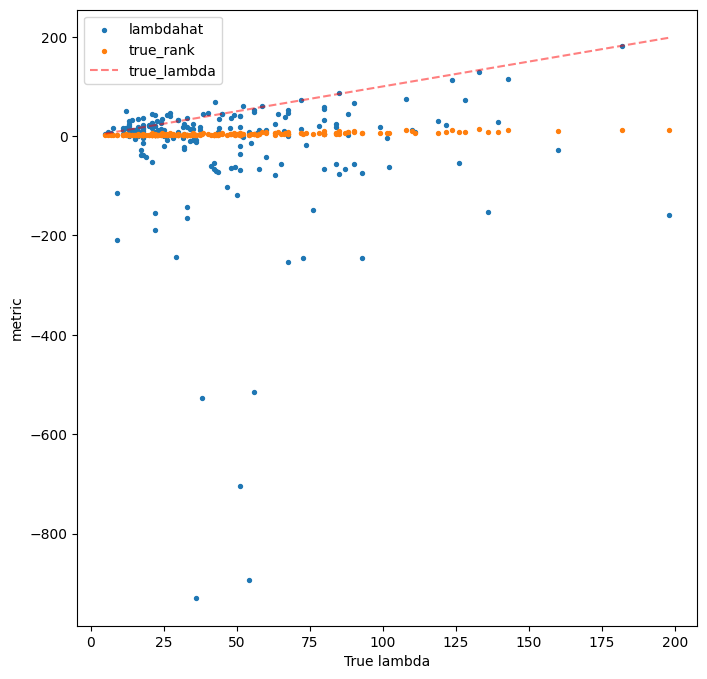

In [111]:
# df = df_data[~df_data["is_true_param"]]
df = df_data
df = df[df["sgd_step_count"] == 400]
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df["true_lambda"], df["lambdahat"], s=8, label="lambdahat")
ax.scatter(df["true_lambda"], df["true_rank"], s=8, label="true_rank")
# ax.scatter(df["true_lambda"], df["model_dim"] / 2, s=8, label="d / 2")
sorted_true_lambda = sorted(df["true_lambda"])
ax.plot(sorted_true_lambda, sorted_true_lambda, label="true_lambda", linestyle="dashed", color="red", alpha=0.5)
ax.legend()

ax.set_xlabel("True lambda")
ax.set_ylabel("metric")
# ax.set_title("True vs estimated lambda");

---
# MISC + Tests
---

In [142]:
np.allclose(model.apply(true_param, x_train), x_train @ true_matrix, atol=1e-5)

True

In [143]:

# a for loop to randomly generate Ms and see how many subset passes _condition
passes = {}
for _ in range(100):
    Ms = np.random.randint(0, 100, size=10)
    if tuple(Ms) in passes:
        continue
    passes[tuple(Ms)] = []
    for indices in generate_indices_subsets(len(Ms)):
        if _condition(indices, Ms):
            passes[tuple(Ms)].append(indices)

np.unique([len(val) for val in passes.values()], return_counts=True)

(array([1]), array([100]))

In [12]:
# a better search method
def generate_candidate_indices(intlist):
    argsort_indices = np.argsort(intlist)
    for i in range(1, len(intlist) + 1):
        yield argsort_indices[:i]

passes = {}
for _ in range(100):
    Ms = np.random.randint(0, 100, size=10)
    if tuple(Ms) in passes:
        continue
    passes[tuple(Ms)] = []
    for indices in generate_candidate_indices(Ms):
        if _condition(indices, Ms):
            passes[tuple(Ms)].append(indices)

np.unique([len(val) for val in passes.values()], return_counts=True)



(array([1]), array([100]))

In [143]:
A = np.random.rand(5, 4)  # Example matrix
reduction_amount = 1    # Amount by which to reduce the rank

np.linalg.matrix_rank(reduce_matrix_rank(A, reduction_amount))


In [220]:

def get_singular_values(matrix):
    """
    Return the singular values of a matrix.

    :param matrix: Input matrix.
    :return: A list of singular values.
    """
    # Perform Singular Value Decomposition
    U, S, Vh = jnp.linalg.svd(matrix, full_matrices=False)
    
    # S contains the singular values
    return S

jtree.tree_map(lambda x: get_singular_values(x), true_param)

{'deep_linear_network/linear': {'w': Array([1.7708387e+00, 1.4593210e+00, 1.0171766e+00, 8.3989543e-01,
         6.2709671e-01, 6.5009992e-08], dtype=float32)},
 'deep_linear_network/linear_1': {'w': Array([1.4080783 , 1.2414557 , 1.0944417 , 0.917447  , 0.80957   ,
         0.59345967, 0.58410025, 0.36330625, 0.3236762 , 0.08388053],      dtype=float32)},
 'deep_linear_network/linear_2': {'w': Array([1.9608408 , 1.8520241 , 1.755757  , 1.5530931 , 1.4234898 ,
         1.2377415 , 1.1145256 , 0.8728106 , 0.8477888 , 0.7129344 ,
         0.53934604], dtype=float32)},
 'deep_linear_network/linear_3': {'w': Array([1.4622892e+00, 1.3065944e+00, 1.2019567e+00, 1.1398048e+00,
         1.1775472e-07, 8.3725773e-08, 6.4771783e-08, 5.3937661e-08,
         4.3606175e-08, 3.6644412e-08, 3.0616370e-08, 1.8090196e-08,
         1.4036087e-08, 8.4396081e-09], dtype=float32)},
 'deep_linear_network/linear_4': {'w': Array([1.753174  , 1.6017103 , 1.387854  , 1.1899551 , 1.0621687 ,
         0.9609756 ,

In [20]:
true_param_config = {
        "method": "random", # random / zero / rand_rank / rand_rank_sv
        "prop_rank_reduce": 0.2, # rand_rank, proportion of matrices selected to have random rank. 
        "mean": 0.0, # rand_rank_sv, mean and std of gaussian to generate SV (singular values) 
        "std": 5.0, 
    }
true_param_config

{'method': 'random', 'prop_rank_reduce': 0.2, 'mean': 0.0, 'std': 5.0}